# Import Packages

In [4]:
#Tensorflow Version 2.7 is needed
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.io
from tensorflow import keras
import tensorflow as tf
import datetime
from numpy import unique
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the simulation data

In [5]:
# Load EIS data-set
# filename : part of the simulation data

filename="xy_data_33k_5circuit_v2.mat"

x=scipy.io.loadmat(filename)["x_data"]
y=scipy.io.loadmat(filename)["y_data"]
y=np.squeeze(y)
x=np.swapaxes(x, 1, 2)
y=tf.keras.utils.to_categorical(y)


# Data Augmentation
new_shape=x.shape
new_shape=np. asarray(new_shape)
new_shape[-1]=new_shape[-1]+3
new_shape=tuple(new_shape)
new_x = np.zeros(new_shape)
new_x[:, :, :3] = x

new_x[:,:,3]=x[:,:,0]*-1
new_x[:,:,4]=x[:,:,1]*-1
new_x[:,:,5]=x[:,:,2]*-1

#Split data
x_train, x_test, y_train, y_test = train_test_split(new_x, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Build a DNN model

In [6]:
# Setup the Experiment 
# drop rate 0.7
# batch size 1024

Experiment_name="Classification_drop07_batch"
fn_tmp=filename.split("xy_data_",1)[1].split(".",1)[0]
Experiment_path="EIS_"+fn_tmp+"_model_"+Experiment_name


#build model
initializer = tf.keras.initializers.HeNormal()


def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
#------------------------------------------------------------------------------
    conv1d = keras.layers.Conv1D(filters=64, kernel_size=32, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(input_layer)

    conv1d = keras.layers.Conv1D(filters=128, kernel_size=16, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(conv1d)
    
    conv1d = keras.layers.Conv1D(filters=256, kernel_size=8, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(conv1d)

    conv1d = keras.layers.Conv1D(filters=512, kernel_size=4, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(conv1d) 

    conv1d = keras.layers.Conv1D(filters=768, kernel_size=2, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(conv1d) 

#------------------------------------------------------------------------------
    connector = keras.layers.SpatialDropout1D(0.7)(conv1d)
    connector = keras.layers.BatchNormalization()(connector)
    connector = keras.layers.GlobalAveragePooling1D()(connector)
#------------------------------------------------------------------------------        
    dense = keras.layers.Dense(1024, 
                               activation="relu", 
                               kernel_initializer=initializer,
                               )(connector)
    
#-------------------------------------------------------------------------------
    output_layer = keras.layers.Dense(5, activation="softmax")(dense)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=x_train.shape[1:])
#Model Summarize
print(model.summary())
#keras.utils.plot_model(model, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           12352     
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 128)          131200    
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 256)          262400    
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 512)          524800    
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 768)          787200    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 768)         0     

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


# Train a model

In [7]:

epochs = 400
batch_size = 1024
Experiment_path=Experiment_path+"_"+str(batch_size) 
print(Experiment_path)


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%y_%m_%d") + "/" \
                      + Experiment_path.split("model_",1)[1]  \
                      +"_"+ filename.split("_",-1)[2] \
                      + datetime.datetime.now().strftime("_%m%d%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                          log_dir=log_dir,
                                          histogram_freq=0,
                                          profile_batch=0)

modelpath= Experiment_path \
           + "/" + "model_{epoch:02d}_{val_loss:.2f}_{val_accuracy:.2f}.h5"

callbacks =[
            keras.callbacks.ModelCheckpoint(
                modelpath, save_best_only=True, 
                monitor="val_loss",mode="min"
                ),
            
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=20, verbose=0,
                mode='min', min_lr=0.000001
                ),
            
            # keras.callbacks.EarlyStopping(monitor="val_loss", patience=60, 
            #                                verbose=1),
            
            #TqdmCallback(verbose=0),
            tensorboard_callback,         
           ]

model.compile(
              optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"],
             )

history = model.fit(
          x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=(x_test,y_test),
          verbose=2,
                   )

df_temp = pd.DataFrame(list(zip(history.history["accuracy"],history.history["val_accuracy"],history.history["loss"],history.history["val_loss"])),
                            columns = ["accuracy","val_accuracy","loss","val_loss"])
df_temp.to_csv(Experiment_path+"/"+"trainig_curve.csv")
print(Experiment_path)



EIS_33k_5circuit_v2_model_Classification_drop07_batch_1024
Epoch 1/400
128/128 - 19s - loss: 1.4704 - accuracy: 0.3294 - val_loss: 1.3651 - val_accuracy: 0.3384 - lr: 0.0010 - 19s/epoch - 146ms/step
Epoch 2/400
128/128 - 6s - loss: 1.2482 - accuracy: 0.4041 - val_loss: 1.4303 - val_accuracy: 0.3558 - lr: 0.0010 - 6s/epoch - 50ms/step
Epoch 3/400
128/128 - 6s - loss: 1.1674 - accuracy: 0.4337 - val_loss: 1.2038 - val_accuracy: 0.4086 - lr: 0.0010 - 6s/epoch - 51ms/step
Epoch 4/400
128/128 - 6s - loss: 1.1100 - accuracy: 0.4599 - val_loss: 1.1803 - val_accuracy: 0.4340 - lr: 0.0010 - 6s/epoch - 51ms/step
Epoch 5/400
128/128 - 6s - loss: 1.0561 - accuracy: 0.4828 - val_loss: 1.1020 - val_accuracy: 0.4550 - lr: 0.0010 - 6s/epoch - 51ms/step
Epoch 6/400
128/128 - 6s - loss: 1.1586 - accuracy: 0.4524 - val_loss: 1.4689 - val_accuracy: 0.3511 - lr: 0.0010 - 6s/epoch - 50ms/step
Epoch 7/400
128/128 - 6s - loss: 1.0979 - accuracy: 0.4741 - val_loss: 1.0568 - val_accuracy: 0.4691 - lr: 0.0010 - 

# Training result visualization

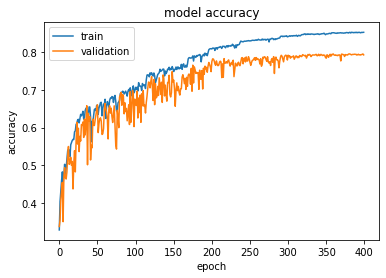

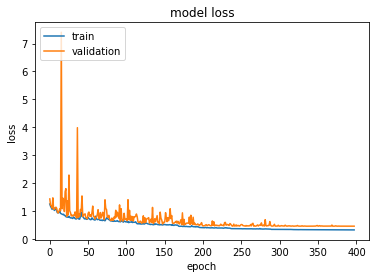

1024/1024 [==============================] - 2s 2ms/step


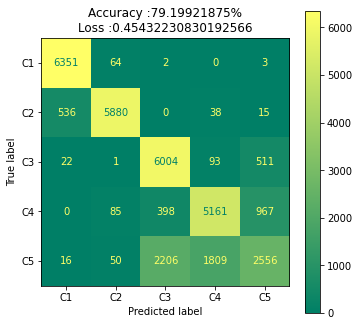

6420 6469 6631 6611 6637


In [10]:
# Load Model

model_to_load = model

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.savefig(Experiment_path+"/"+"accuracy.png")
#plt.close(fig)
plt.show()
# summarize history for loss
fig=plt.figure()
plt.plot(history.history["loss"][1:-1])
plt.plot(history.history["val_loss"][1:-1])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.savefig(Experiment_path+"/"+"loss.png")
#plt.close(fig)
plt.show()

#predict
predict_model = model

x_t= x_test
y_t= y_test
# x_t= x_train
# y_t= y_train

m_ev=predict_model.evaluate(x_t,y_t)
y_pred=predict_model.predict(x_t)
y_pred_class = np.zeros(len(y_t))
y_test_class = np.zeros(len(y_t))

for idx in range(len(y_t)):

    y_pred_class[idx]=np.argmax(y_pred[idx])

test_list2=y_pred_class
    
for idx in range(len(y_t)):

    y_test_class[idx]=np.argmax(y_t[idx])

test_list1=y_test_class
        
cm=confusion_matrix(test_list1,test_list2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["C1","C2"
                              ,"C3","C4","C5"])
px = 1/plt.rcParams["figure.dpi"]  # pixel in inches
fig, ax = plt.subplots(figsize=(400*px, 400*px))
disp.plot(cmap="summer",ax=ax)
cfmc_title="Accuracy :"+str(m_ev[1]*100)+"%"+"\n"+"Loss :"+str(m_ev[0])
plt.title(cfmc_title)
plt.savefig(Experiment_path+"/"+"CMatrix.png")
plt.show()

c1,c2,c3,c4,c5=0,0,0,0,0
for idx in range(len(test_list1)):
    if test_list1[idx]==0:c1=c1+1
    if test_list1[idx]==1:c2=c2+1    
    if test_list1[idx]==2:c3=c3+1  
    if test_list1[idx]==3:c4=c4+1
    if test_list1[idx]==4:c5=c5+1   
print(c1,c2,c3,c4,c5)


In [ ]:
# Dulyawat Doonyapisut Email:charting9@gmail.com